In [1]:
import pandas as pd
import numpy as np
import csv
from scipy import stats
import math
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import datetime
from datetime import datetime, timedelta
import holidays
pd.options.display.max_rows = 50

pd.options.display.float_format = '{:.2f}'.format

In [2]:
df = pd.read_csv("ben_intraday_data.csv")
daily_data = pd.read_csv('ben_daily.csv', parse_dates=['DATE'])
df['str_date'] = df['date']
df['datetime'] = df['date'] + ' ' + df['time']
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])
df['symbol'] = df['sym_root'] + df['sym_suffix']
df.loc[df['sym_suffix'].isnull(), 'symbol'] = df['sym_root']

In [3]:
data = df.merge(daily_data[['DATE', 'symbol', 'total_vol']], how='left', left_on=['date', 'symbol'], right_on = ['DATE', 'symbol'])
data.index = pd.DatetimeIndex(df['datetime'])
data = data.drop(['DATE','datetime'],axis=1)
data = data.between_time('09:31:00', '15:59:00')
data['perc_vol'] = data['size']/data['total_vol']
LUV = data.loc[data.symbol == 'LUV'].copy()

In [4]:
LUV.resample('60s').asfreq()
LUV = LUV.between_time('09:31:00', '15:59:00')
LUV['cum_vol'] = np.nan
trading_days = list(pd.to_datetime(LUV.date.unique()))
for day in trading_days:
    LUV.loc[day==LUV.date, 'cum_vol'] = LUV.loc[day==LUV.date,'perc_vol'].cumsum()

In [31]:
minutes = LUV.loc[LUV.date==trading_days[0]].index

avg_cum_dist = pd.Series(dtype='float64')
for minute in minutes:
    avg_cum_dist.loc[minute] = LUV.loc[LUV.index.time == minute.time(), 'cum_vol'].mean()
    LUV.loc[LUV.index.time == minute.time(), 'avg_cum_vol'] = avg_cum_dist.loc[minute]  

# avg_cum_dist.plot()
# plt.show()
# for day in trading_days:


In [32]:
avg_per_dist = pd.Series(dtype = 'float64')
for minute in minutes:
    if minute.time() == minutes[0].time():
        avg_per_dist[minute] = avg_cum_dist[minute]
    else:
        avg_per_dist[minute] = avg_cum_dist[minute] - avg_cum_dist[minute + timedelta(minutes = -1)]
    LUV.loc[LUV.index.time == minute.time(), 'avg_perc_vol'] = avg_per_dist.loc[minute]  


2019-01-02 09:31:00   0.01
2019-01-02 09:32:00   0.01
2019-01-02 09:33:00   0.01
2019-01-02 09:34:00   0.00
2019-01-02 09:35:00   0.01
                      ... 
2019-01-02 15:55:00   0.01
2019-01-02 15:56:00   0.01
2019-01-02 15:57:00   0.01
2019-01-02 15:58:00   0.01
2019-01-02 15:59:00   0.02
Length: 389, dtype: float64

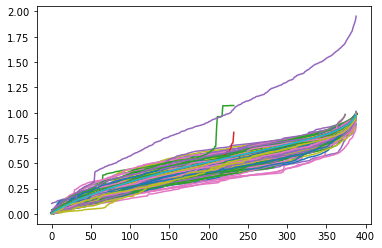

In [22]:
for i in range(0,180):
    plt.plot(LUV.loc[LUV.date==trading_days[i], ['cum_vol', 'avg_cum_vol']].reset_index(drop=True))
plt.show()



<AxesSubplot:>

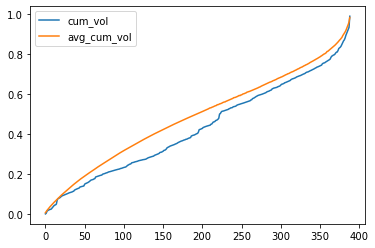

In [23]:
LUV.loc[LUV.date==trading_days[i], ['cum_vol', 'avg_cum_vol']].reset_index(drop=True).plot()

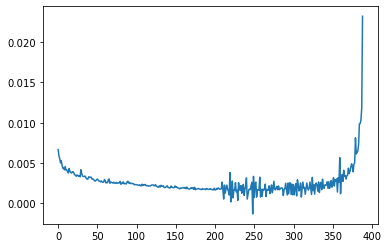

In [41]:
plt.plot(avg_per_dist.reset_index(drop=True))

<AxesSubplot:>

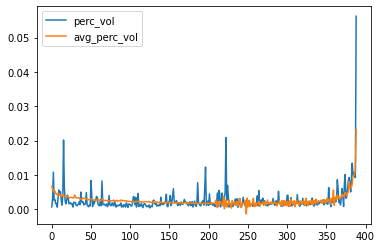

In [42]:
LUV.loc[LUV.date==trading_days[i], ['perc_vol', 'avg_perc_vol']].reset_index(drop=True).plot()

In [57]:
check = LUV.loc[LUV.date==trading_days[i], ['avg_perc_vol']].reset_index(drop=True)
a1, b1, c1, d1 = stats.beta.fit(check, loc=0, scale=1)

In [68]:
b1

261932728457.1644

/Users/bengoldman/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:607: RuntimeWarning: divide by zero encountered in _beta_pdf
  return _boost._beta_pdf(x, a, b)


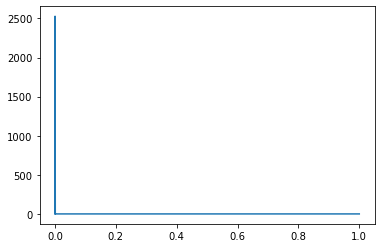

In [71]:
x = np.linspace(0, 1, 10000); plt.plot(x, stats.beta.pdf(x, a1, 20000))

In [421]:
# day = day.resample('60s').asfreq().fillna(0)
# series = day.perc_vol.cumsum()
# num = series.index[0].minute -31
# idx = pd.date_range(series.index[0], periods=num, freq='-60s')
# idx = sorted(idx)
# series = series.append(pd.Series(np.repeat(0, len(idx)), index=idx)).sort_index()
# series

In [422]:
# total = pd.Series()
# # nyse.valid_days(start_date='2016-12-20', end_date='2017-01-10')
# # cur = BACPRE.index[0]
# for i in range(0,4):
#     compare = cur.strftime('%Y-%m-%d')
# #     print(cur.weekday())
#     day = BACPRE.loc[BACPRE.str_date == compare]
#     day = day.resample('60s').asfreq().fillna(0)
#     series = day.perc_vol.cumsum()
# #     print (series.index[0].minute -31)
#     cur = cur + timedelta(days = 1)
#     if (cur.weekday() == 5):
#         cur = cur + timedelta(days = 2)
#     num = max(0,series.index[0].minute -31)
#     idx = pd.date_range(series.index[0], periods=num, freq='-60s')
#     idx = sorted(idx)
#     series = series.append(pd.Series(np.repeat(0, len(idx)), index=idx)).sort_index()
#     total = pd.concat(['series'],['total'])

,date,time,sym_root,sym_suffix,size,str_date,symbol,total_vol,perc_vol,cum_vol,avg_cum_vol
datetime,,,,,,,,,,,
2019-01-02 09:31:00,2019-01-02,09:31:00,LUV,NaN,35979.00,2019-01-02,LUV,3081736.00,0.01,0.01,0.01
2019-01-02 09:32:00,2019-01-02,09:32:00,LUV,NaN,18420.00,2019-01-02,LUV,3081736.00,0.01,0.02,0.01
2019-01-02 09:33:00,2019-01-02,09:33:00,LUV,NaN,3406.00,2019-01-02,LUV,3081736.00,0.00,0.02,0.02
2019-01-02 09:34:00,2019-01-02,09:34:00,LUV,NaN,3149.00,2019-01-02,LUV,3081736.00,0.00,0.02,0.02
2019-01-02 09:35:00,2019-01-02,09:35:00,LUV,NaN,7702.00,2019-01-02,LUV,3081736.00,0.00,0.02,0.03
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 15:55:00,2021-12-31,15:55:00,LUV,NaN,21883.00,2021-12-31,LUV,5438043.00,0.00,0.95,0.93
2021-12-31 15:56:00,2021-12-31,15:56:00,LUV,NaN,43088.00,2021-12-31,LUV,5438043.00,0.01,0.96,0.94
2021-12-31 15:57:00,2021-12-31,15:57:00,LUV,NaN,21964.00,2021-12-31,LUV,5438043.00,0.00,0.96,0.95


In [423]:
avg_cum_dist

2019-01-02 09:31:00   0.01
2019-01-02 09:32:00   0.01
2019-01-02 09:33:00   0.02
2019-01-02 09:34:00   0.02
2019-01-02 09:35:00   0.03
                      ... 
2019-01-02 15:55:00   0.93
2019-01-02 15:56:00   0.94
2019-01-02 15:57:00   0.95
2019-01-02 15:58:00   0.96
2019-01-02 15:59:00   0.98
Length: 389, dtype: float64